# Spark - Utilisation sur le serveur UbuntuAnaconda :

## La console PySpark :

Lancemement de la console `pyspark` dans un bash linux :

In [ ]:
/opt/spark/bin/pyspark

Tapez `spark` et appuyez sur Entrée.  
La SparkSession devrait alors être affiché.

---
---
## 1 - Architecture Spark :

Les applications Spark se composent d’un pilote (« driver process ») et de plusieurs exécuteurs (« executor processes »).  
Il peut être configuré pour être lui-même l’exécuteur (local mode) ou en utiliser autant que nécessaire pour traiter l’application, Spark prenant en charge la mise à l’échelle automatique par une configuration d’un nombre minimum et maximum d’exécuteurs.

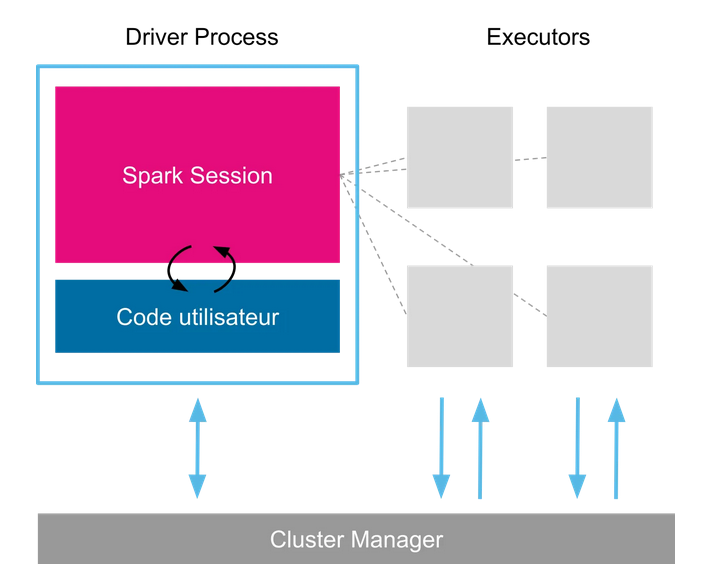

Spark crée des jobs, des stages et des tasks.  
Les jobs se composent de stages, et les stages se composent de tâches.  
Les stages sont généralement exécutés séquentiellement, tandis que les tâches peuvent être exécutées en parallèle dans le cadre d’un seul stage.

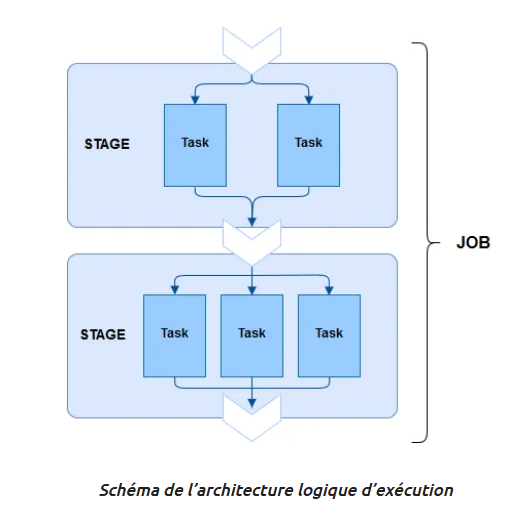

Deux points clés à comprendre sur les applications Spark à ce stade sont :

* Spark emploie un gestionnaire de groupe (cluster manager) qui assure le suivi des ressources disponibles.
* Le processus de pilotage (driver process) est responsable de l’exécution le programme à travers les exécuteurs pour accomplir une tâche donnée.


Les exécuteurs, pour la plupart, exécuteront toujours du code Spark.  
Cependant, le conducteur peut être « piloté » à partir d’un certain nombre de langues différentes par l’intermédiaire des API de différents langages.

---
---
## 2 - Concepts principaux :

### 2.1 - SparkSession :

L’application Spark est contrôlé grâce à un processus de pilotage (driver process) appelé SparkSession.  
Une instance de SparkSession est la façon dont Spark exécute les fonctions définis par l’utilisateur dans l’ensemble du cluster.  
Une SparkSession correspond toujours à une application Spark.  
En Scala et Python, la variable est disponible sous spark lorsque vous démarrez la
console.

En python, cela ressemble à :  
`<pyspark.sql.session.SparkSession at 0x7efda4c1ccd0>`

---
### 2.2 - Dataframes :

Un DataFrame Spark peut s’étaler sur des milliers d’ordinateurs.  
La raison pour laquelle les données sont placées sur plus d’un l’ordinateur est assez simple :  
soit les données sont trop volumineuses pour tenir sur une seule machine, soit il serait simplement
trop long d’effectuer des calculs sur ces données sur une seule machine.

Par exemple, pour créer un simple DataFrame avec une colonne number contenant 1 000 lignes avec des valeurs de 0 à 999.  
Cette plage de nombres représente une collection distribuée.

In [ ]:
# Python
myRange = spark.range(1000).toDF("number")

---
### 2.3 - Partitions :

Pour permettre à chaque exécuteurs de travailler en parallèle, Spark décompose les données en morceaux appelés des partitions.  
Une partition est un ensemble de rangées qui se trouvent sur une machine physique du cluster.  
Les partitions de DataFrame représentent la manière dont les données sont physiquement réparties dans le groupe de machines pendant l’exécution.

Si il n’y a qu’une seule partition, Spark aura un parallélisme de un, même si le cluster est composés de milliers d’exécuteurs.  
Si il y a plusieurs partitions mais un seul exécuteur, Spark aura toujours un parallélisme de un car il n’y a qu’une seule ressource de calcul.

---
### 2.4 - Transformations :

Dans Spark, les structures de données de base sont immuables, ce qui signifie qu’elles ne peuvent pas être modifiées après avoir été créé.  
Pour « changer » un DataFrame, il faut indiquer à Spark comment le modifier.  
Ce sont les transformations.

Par exemple, récupérons tous les nombres paires du DataFrame créé précédemment :

In [ ]:
# Python
divisBy2 = myRange.where("number % 2 = 0")

Notez que ces opérations ne renvoient aucun résultat.  
C’est parce que nous n’avons spécifié qu’une transformation abstraite, et Spark n’agira pas sur les transformations tant que nous n’aurons pas appelé une action (décrit plus bas).  
Il y a deux types de transformations : celles qui spécifient des dépendances étroites, et celles qui spécifient des dépendances larges.

Les transformations consistant en des dépendances étroites (appellées également transformations étroites ou narrow transformations) sont celles pour lesquelles chaque partition d’entrée ne contribuera qu’à une seule partition de sortie.  
Dans le code précédent, le where spécifie une dépendance étroite, où une seule partition contribue à au maximum une partition de sortie.

A l’inverse, une dépendance large (ou transformation large) aura des partitions d’entrée qui contribuent à de nombreuses partitions de sortie.  
Spark effectue donc une lazy evalutation qui signifie que Spark attendra le tout dernier moment pour exécuter le graphique des instructions de calcul. Dans Spark, au lieu de modifier les données immédiatement lorsque une opération est définie, un plan de transformations à appliquer aux données sources est élaboré. En attendant le dernier moment pour exécuter le code (c’est-à-dire la prochaine action), Spark compile ce plan à partir du DataFrame brut à un plan physique qui fonctionnera aussi efficacement que possible dans l’ensemble du cluster.

---
## 2.5 - Actions :

Les transformations permettent de construire un plan de transformation logique.  
Pour déclencher le calcul, il faut utiliser une action.  
Une action demande à Spark de calculer un résultat à partir d’une série de transformations.

L’action la plus simple est le count, qui nous donne le nombre total d’enregistrements dans un DataFrame.  
Par exemple :

In [ ]:
divisBy2.count()

La sortie du code précédent doit être 500.  
Bien sûr, le comptage n’est pas la seule action.  
Il y a trois types d’actions :

* Actions de visualisation des données
* Actions visant à collecter des données sur les objets natifs dans le langage de programmation respectif
* Actions d’écriture sur les sources de données de sortie


En précisant cette action, nous avons lancé une tâche Spark qui gère la transformation de filtrage (une transformation étroite), puis une agrégation (une transformation large) qui effectue les comptages sur chaque partition, puis une collecte, qui renvoie notre résultat à un objet natif au langage correspondant.